Response time

In [498]:
"""IMPORTS
"""

import sys
#sys.path.append("../DBL-Data-Challenge")
from database.connect import getConnection
import pandas as pd
import seaborn as sns
sns.set()
import random
import matplotlib.pyplot as plt
from globals import airlineIDs
import re

"""MODEL IMPORTS
""""""
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)"""

'MODEL IMPORTS\n\nfrom transformers import AutoModelForSequenceClassification\nfrom transformers import TFAutoModelForSequenceClassification\nfrom transformers import AutoTokenizer, AutoConfig\nimport numpy as np\nfrom scipy.special import softmax\n# Preprocess text (username and link placeholders)\ndef preprocess(text):\n    new_text = []\n    for t in text.split(" "):\n        t = \'@user\' if t.startswith(\'@\') and len(t) > 1 else t\n        t = \'http\' if t.startswith(\'http\') else t\n        new_text.append(t)\n    return " ".join(new_text)\nMODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"\ntokenizer = AutoTokenizer.from_pretrained(MODEL)\nconfig = AutoConfig.from_pretrained(MODEL)\n# PT\nmodel = AutoModelForSequenceClassification.from_pretrained(MODEL)\n#model.save_pretrained(MODEL)'

In [499]:
import time
def execution_time(start_time):
    return ("--- %s seconds ---" % (time.time() - start_time))

In [500]:
try:
    connection1 = getConnection()
except Exception:
    print("✖️ Error while connecting to MySQL engine database.")
    print("ℹ️ Please make sure the environment file `.env` is located at"+
        "the project root directory and contains proper configuration.")
    raise

In [501]:
"""Loads all the relevant data, this takes ~10 min.
"""
# Keeps track of execution time
start_time = time.time()

# Connects to database
print(f'Connection successful! {execution_time(start_time)}')
cursor = connection1.cursor()

#print("The tweets are being queried")
#query="SELECT id, text, in_reply_to, timestamp, user_mentions, user_id FROM tweets"
#cursor.execute(query)

#print('The tweets are being fetched')
#texts = cursor.fetchall()
#number_tweets = cursor.rowcount
#print("Total number of rows in table: ", number_tweets)

# Index column is being added
#print("Index is being added")
#query= "DROP TABLE tweets_with_index"
#cursor.execute(query)

# Create new table will the relevant data
#print(f'Table with index is being created {execution_time(start_time)} ')
#query= "CREATE TABLE tweets_with_index SELECT ROW_NUMBER() OVER() AS row_num, id, text, in_reply_to, timestamp, user_mentions, user_id FROM tweets"
#cursor.execute(query)
#print(f'Index added {execution_time(start_time)} ')

# Placement of column names
id = 1
tweet_text = 2
in_reply_to = 3
timestamp = 4
user_mentions = 5
user_id = 6

print(f'The tweets are being fetched {execution_time(start_time)} ')
query="SELECT row_num, id, text, in_reply_to, timestamp, user_mentions, user_id FROM tweets_with_index"
cursor.execute(query)
texts = cursor.fetchall()
number_tweets = cursor.rowcount
print('Total number of rows in table: ', number_tweets, {execution_time(start_time)})

# Generate random list
randomlist = []
for i in range(0, 6000):
    n = random.randint(0, number_tweets-1)
    randomlist.append(n)

# Make list of languages
print("The dataframe is being created")
df_data = pd.DataFrame(columns=['mentions', 'tweet_sentiment', 'response_time', 'tweet_length'])
for i in randomlist:  
    dict = {'mentions': ['Null'], 'tweet_sentiment': [(0,0,0)], 'response_time': [0], 'tweet_length': [0]}
    try:
        # Sentiment detection -> tweet_sentiment (tuple: pos, neg, neu)
        """text = preprocess(str(texts[i][tweet_text]))
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        score_tuple = (scores[ranking[0]], scores[ranking[1]], scores[ranking[2]])
        dict['tweet_sentiment'] = score_tuple"""
        
        # User mentions -> airline
        dicts_str = (texts[i][user_mentions])
        tweet_mentions_list = re.findall("'id':\s*(\d*)", dicts_str)
        dict['mentions'] = tweet_mentions_list
    except Exception:
        pass
    
    try:
        # Response time -> response_time
        self_time = texts[i][timestamp]
        replied_id = texts[i][in_reply_to]
        if replied_id == 0:
            dict['response_time'] = 0
        else:
            for tuple in texts:
                if tuple[id] == replied_id:
                    replied_time = tuple[timestamp]
                    time = self_time - replied_time
                    dict['response_time'] = time      
    except Exception:
        pass

    try:
        tweet_length = len(texts[i][tweet_text])
        dict['tweet_length'] = tweet_length   
    except:
        pass    
    # Add to dataframe
    df_dict = pd.DataFrame([dict])
    df_data = pd.concat([df_data, df_dict], ignore_index=True)
df_data.head()

#print(sentiment_list)
#print(user_mention_list)

# Add the result to the table (Probably needs some modifications)
"""
print("The tweets are being added to the table")
for i, j in enumerate(lang_list): # i = index, j = language
    query = f"UPDATE tweets_with_index SET lang = '{str(j)}' WHERE row_num = {int(i+1)}"
    cursor.execute(query)
"""

"""
print("A selection is being fetched to show that everything when correctly")
query = "SELECT * FROM tweets_with_index LIMIT 5"
cursor.execute(query)
head = cursor.fetchall()

print("The first 5 rows are being printed:")
for row in head:
    print(row)

"""
cursor.close()
connection1.close()
print('Connection closed!')

Connection successful! --- 1.2636184692382812e-05 seconds ---
The tweets are being fetched --- 0.0006918907165527344 seconds --- 
Total number of rows in table:  6094135 {'--- 9.898717880249023 seconds ---'}
The dataframe is being created
Connection closed!


In [502]:
df_data.head()

,mentions,tweet_sentiment,response_time,tweet_length
0,[1134331688996167680],"[(0, 0, 0)]",0,140
1,[999411043356069888],"[(0, 0, 0)]",0,133
2,"[57248499, 218730857]","[(0, 0, 0)]",0,140
3,"[18332190, 20604674, 57451912, 18332190, 18658...","[(0, 0, 0)]",[0],140
4,"[211300043, 42479903]","[(0, 0, 0)]",0,140


In [503]:
for i in range(0, len(df_data.index)):
    if df_data.loc[i, 'response_time'] == [0]:
        df_data.loc[i, 'response_time'] = 0

In [504]:
df_data['response_time'].describe(include='all')

count     6000
unique    1471
top          0
freq      4530
Name: response_time, dtype: int64

In [505]:
df_response = df_data[['response_time']]
df_response.head()


,response_time
0,0
1,0
2,0
3,0
4,0


In [506]:
from statistics import mean

respone_list = []
for i in range(0, len(df_response.index)):
    if df_response.loc[i, 'response_time'] != 0:
        respone_list.append(df_response.loc[i, 'response_time'])

average = mean(respone_list)/(1000*60*60) # average in hours
print(average)

16.348355769463343


In [507]:
df_response.head()

,response_time
0,0
1,0
2,0
3,0
4,0


In [508]:
df_response_count = pd.DataFrame(columns=['reply', 'no_reply'])
df_response_count['reply'] = [0]
df_response_count['no_reply'] = [0]

for i in range(0, len(df_response.index)):
    if df_response.loc[i, 'response_time'] == 0:
        df_response_count.loc[0, 'no_reply'] = df_response_count.loc[0, 'no_reply'] + 1
    else:
        df_response_count.loc[0, 'reply'] = df_response_count.loc[0, 'reply'] + 1


nr_reply = df_response_count.loc[0, 'reply']
nr_no_reply = df_response_count.loc[0, 'no_reply']

df_response_count.loc[0, 'reply'] = nr_reply / (nr_reply + nr_no_reply)
df_response_count.loc[0, 'no_reply'] = nr_no_reply / (nr_reply + nr_no_reply)

df_response_count.head()

,reply,no_reply
0,0.245,0.755


Text(0, 0.5, 'Percentage [%]')

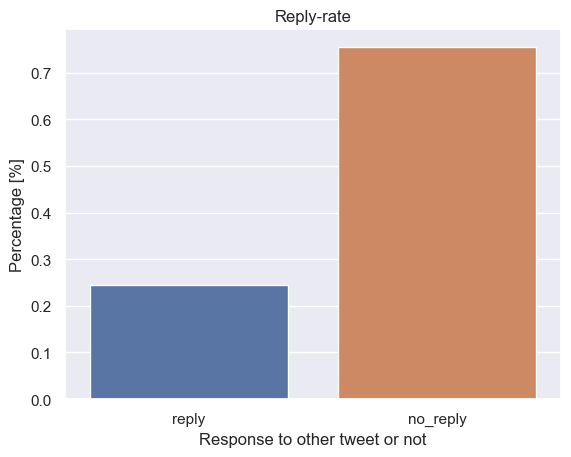

In [509]:
ax = sns.barplot(df_response_count)
ax.set_title("Reply-rate")
ax.set_xlabel('Response to other tweet or not')
ax.set_ylabel('Percentage [%]')

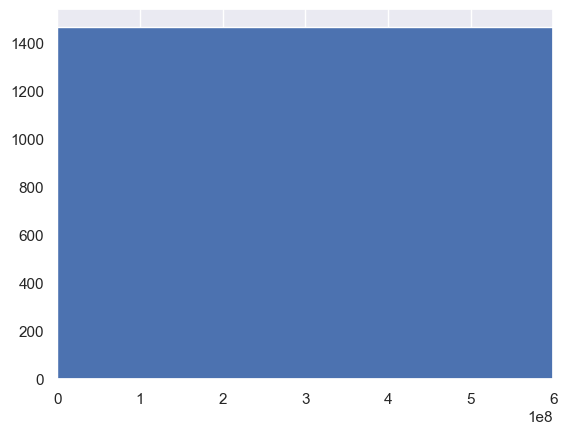

In [510]:
plt.hist(respone_list)
plt.xlim((0, 6e8))
plt.show() 

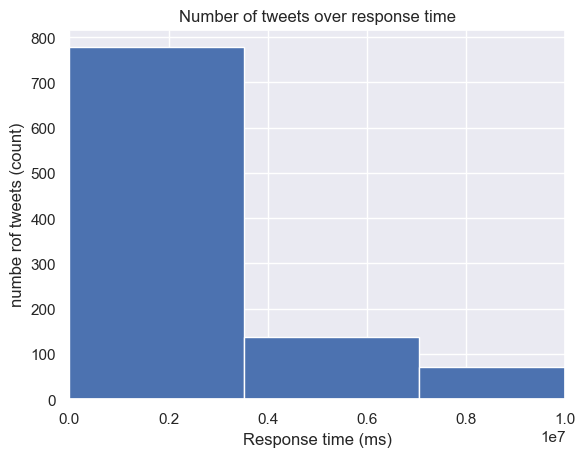

In [511]:
plt.hist(respone_list, bins=5000)
plt.xlim((0, 10e6))
plt.title('Number of tweets over response time')
plt.xlabel('Response time (ms)')
plt.ylabel('numbe rof tweets (count)')
plt.show() 

In [512]:
df_clean = df_data.drop('tweet_sentiment', axis=1)
df_clean.head()

,mentions,response_time,tweet_length
0,[1134331688996167680],0,140
1,[999411043356069888],0,133
2,"[57248499, 218730857]",0,140
3,"[18332190, 20604674, 57451912, 18332190, 18658...",0,140
4,"[211300043, 42479903]",0,140


In [513]:
# Detect the users 
# (what airline is it? Or is it not an airline?)
df_clean['user_mentions'] = 'Null'
df_clean['airline'] = 'Null'
df_clean['mention_count'] = 'Null'

# For every list of mentions per tweet
for i, mentions in enumerate(df_clean['mentions']):
    # Count the number of user_mentions
    df_clean['mention_count'][i] = len(mentions)

    # Detect the airline
    mentions_list = []
    airline = 'no_airline'
    # check for every mention
    added = False
    for mention in mentions:
        # if the mention is an airline
        added = False
        for key in airlineIDs:
            if int(mention) == int(airlineIDs[key]):
                mentions_list.append(key)
                airline = key
                added = True
                continue
        if added == False:
            mentions_list.append('no_airline')
    df_clean['user_mentions'][i] = mentions_list
    df_clean['airline'][i] = airline

df_user = df_clean.drop(['mentions', 'user_mentions'], axis=1)

In [514]:
df_user.head()

,response_time,tweet_length,airline,mention_count
0,0,140,no_airline,1
1,0,133,no_airline,1
2,0,140,Qantas,2
3,0,140,BritishAirways,5
4,0,140,no_airline,2


In [515]:
df_time_mention = df_user.drop('airline', axis=1)
df_time_mention.head()

,response_time,tweet_length,mention_count
0,0,140,1
1,0,133,1
2,0,140,2
3,0,140,5
4,0,140,2


In [516]:
df_time_mention['mention_count'].describe()

count     6000
unique      13
top          1
freq      3048
Name: mention_count, dtype: int64

In [517]:
df_time_mention_percent = df_time_mention.groupby(['mention_count'])['response_time'].agg(['count'])
df_time_mention_percent.head()

,count
mention_count,
0,809
1,3048
2,1235
3,474
4,202


In [518]:
df_time_mention_percent = (df_time_mention_percent['count']/1000).to_frame()
df_time_mention_percent.head()

,count
mention_count,
0,0.809
1,3.048
2,1.235
3,0.474
4,0.202


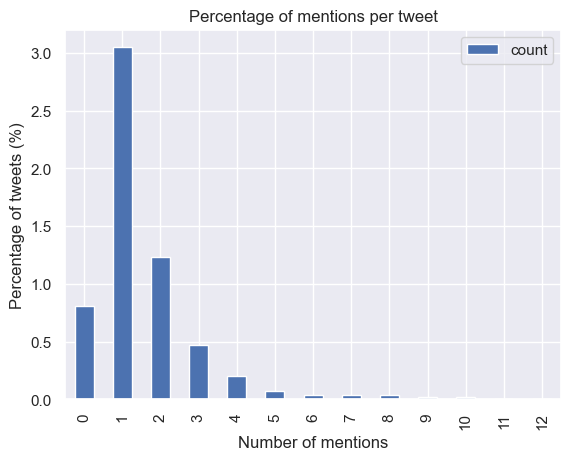

In [519]:
ax = df_time_mention_percent.plot(kind='bar', ) 
ax.set_xlabel('Number of mentions')
ax.set_ylabel('Percentage of tweets (%)')
ax.set_title('Percentage of mentions per tweet');

In [520]:
df_time_mention2 = df_time_mention.groupby(['mention_count']).agg({'response_time':['mean','std']})
df_time_mention2
#df_user_grouped_mention_time.head()

response_time              
                       mean           std
mention_count                            
0              2.459637e+05  6.315793e+06
1              1.006941e+07  8.841374e+07
2              1.642101e+07  1.288253e+08
3              6.256475e+07  8.199402e+08
4              1.038090e+07  3.558685e+07
5              1.880961e+07  6.834264e+07
6              1.734567e+07  7.101961e+07
7              1.012152e+07  2.155623e+07
8              2.956056e+07  6.025685e+07
9              7.119265e+06  1.580064e+07
10             8.963012e+05  2.690929e+06
11             1.355020e+05  3.319108e+05
12             4.599132e+06  9.198264e+06

In [521]:
df_time_mention3 = (df_time_mention2['response_time']['mean'] / (1000 * 60 * 60)).to_frame()
df_time_mention3.head()


,mean
mention_count,
0,0.068323
1,2.797057
2,4.561391
3,17.379096
4,2.883582


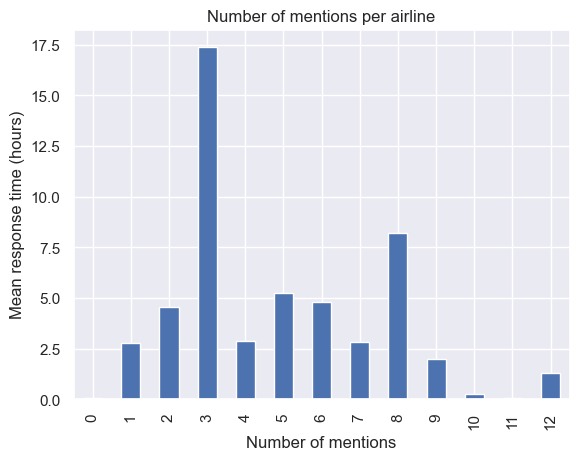

In [522]:
ax = df_time_mention3['mean'].plot(kind='bar', ) 
ax.set_xlabel('Number of mentions')
ax.set_ylabel('Mean response time (hours)')
ax.set_title('Number of mentions per airline');

In [523]:
df_user.head()

,response_time,tweet_length,airline,mention_count
0,0,140,no_airline,1
1,0,133,no_airline,1
2,0,140,Qantas,2
3,0,140,BritishAirways,5
4,0,140,no_airline,2


In [524]:
df_user_grouped = df_user.groupby(['airline'])[['mention_count']].mean()
df_user_grouped.head()

,mention_count
airline,
AirFrance,2.735294
AmericanAir,2.194175
BritishAirways,1.990530
EtihadAirways,3.016129
KLM,2.495283


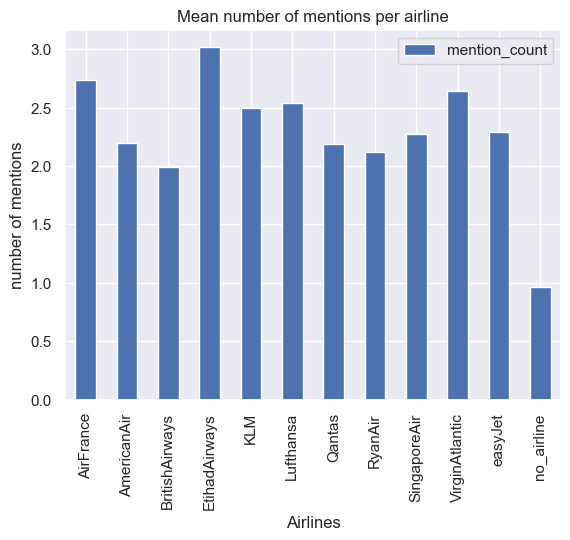

In [525]:
ax = df_user_grouped.plot(kind='bar', stacked=True, ) 
ax.set_xlabel('Airlines')
ax.set_ylabel('number of mentions')
ax.set_title('Mean number of mentions per airline');

In [526]:
df_user.head()

,response_time,tweet_length,airline,mention_count
0,0,140,no_airline,1
1,0,133,no_airline,1
2,0,140,Qantas,2
3,0,140,BritishAirways,5
4,0,140,no_airline,2


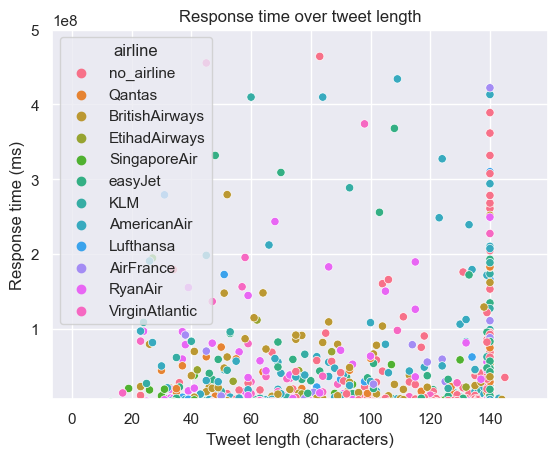

In [527]:
ax = sns.scatterplot(df_user, x='tweet_length', y='response_time', hue='airline')
ax.set_ylim(5999999, 500000000)
ax.set_xlabel('Tweet length (characters)')
ax.set_ylabel('Response time (ms)')
ax.set_title('Response time over tweet length');

The positive correlation could be due to re-tweeting one's own tweet to get more words.
Regression model removing the ≈ word limit.